Can a model predict the correct choice to make to win a game?

In [59]:
import os
import time
import glob
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model, preprocessing, model_selection
%matplotlib inline

In [2]:
data_dir = "generated_games"

In [3]:
print("CSVs in data_dir:")
files = glob.glob(os.path.join(data_dir, "*.csv"))
print([os.path.basename(file) for file in files])

CSVs in data_dir:
['random_choice_games.csv']


In [4]:
fp = os.path.join(data_dir, "random_choice_games.csv")
raw = pd.read_csv(fp)

In [24]:
winning_moves = raw.groupby("game_no").last()

In [31]:
# All features are categorical

to_encode = winning_moves.drop("choice", axis=1)
encoder = preprocessing.OneHotEncoder()
X = encoder.fit_transform(to_encode)

scaler = np.array([3] * (X.shape[1]))
X = X / scaler

In [34]:
y = winning_moves["choice"]

In [35]:
CV = 5

In [44]:
# Fit classifier w/ CV-fold Cross Validation

cs = np.logspace(-3, 3, 20)
logit = linear_model.LogisticRegression(penalty='l2', fit_intercept=False,
                                        multi_class='multinomial', solver='lbfgs')

clf = model_selection.GridSearchCV(logit, param_grid={'C': cs}, cv=CV)

start = time.time()
clf.fit(X, y)
end = time.time()

print(f"Fit took {round(end - start, 3)} sec")
print(f"Data had shape: ({X.shape[0]}, {X.shape[1]})")
print(f"Number of Cs cross-validated: {len(cs)}\n")
print(clf)

Fit took 93.046 sec
Data had shape: (20000, 126)
Number of Cs cross-validated: 20

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-03,   2.06914e-03,   4.28133e-03,   8.85867e-03,
         1.83298e-02,   3.79269e-02,   7.84760e-02,   1.62378e-01,
         3.35982e-01,   6.95193e-01,   1.43845e+00,   2.97635e+00,
         6.15848e+00,   1.27427e+01,   2.63665e+01,   5.45559e+01,
         1.12884e+02,   2.33572e+02,   4.83293e+02,   1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)


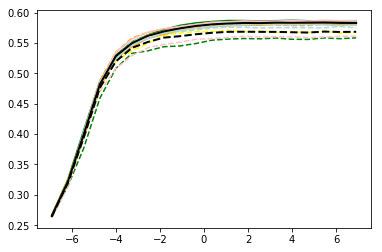

In [45]:
# Plot results per Fold

trains = [clf.cv_results_[f"split{i}_train_score"] for i in range(CV)]
tests = [clf.cv_results_[f"split{i}_test_score"] for i in range(CV)]
all_vals = np.array(trains + tests)
max_val = all_vals.max()
min_val = all_vals.min()

ax = plt.subplot()
# ax.set_ylim((0, 1))

cs = np.log(clf.param_grid["C"])

cmap = {0: 'green', 1: 'yellow', 2: 'orange', 3: 'lightblue', 4: 'pink'}

for i in range(CV):
    
    train_nm = f"split{i}_train_score"
    split_train = clf.cv_results_[train_nm]
    
    test_nm = f"split{i}_test_score"
    split_test = clf.cv_results_[test_nm]
    
    ax.plot(cs, split_train, color=cmap[i])
    ax.plot(cs, split_test, color=cmap[i], linestyle='--')
    
ax.plot(cs, clf.cv_results_["mean_train_score"], color='black', linewidth=2)
ax.plot(cs, clf.cv_results_["mean_test_score"], color='black', linestyle='--', linewidth=2)

Using keras

In [60]:
# https://github.com/dcoxnard/nyc17_ds13/blob/master/class_lectures/week08-fletcher2/03-deep_learning_keras/Deep%20Learning%20for%20NLP-%20An%20Application-based%20Intro.ipynb

test_share = .25

ix = math.floor(X.shape[0] * test_share)
X_train = X[:ix]
X_test = X[ix:]
y_train = y[:ix]
y_test = y[ix:]

In [52]:
os.environ["KERAS_BACKEND"] = 'tensorflow'
import keras

Using TensorFlow backend.


In [56]:
input_shape = (126,)  # X columns

model = keras.Sequential()
model.add(keras.layers.Dense(16, input_shape=input_shape, activation='relu'))
model.add(keras.layers.Dense(7, activation='softmax'))

In [58]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [61]:
history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_split=.25);

Train on 3750 samples, validate on 1250 samples
Epoch 1/200
3750/3750 [==============================] - 0s 85us/step - loss: 1.9796 - acc: 0.1355 - val_loss: 1.9588 - val_acc: 0.1576
Epoch 2/200
3750/3750 [==============================] - 0s 25us/step - loss: 1.9399 - acc: 0.1837 - val_loss: 1.9311 - val_acc: 0.2136
Epoch 3/200
3750/3750 [==============================] - 0s 25us/step - loss: 1.9181 - acc: 0.2285 - val_loss: 1.9155 - val_acc: 0.2288
Epoch 4/200
3750/3750 [==============================] - 0s 25us/step - loss: 1.9051 - acc: 0.2453 - val_loss: 1.9058 - val_acc: 0.2264
Epoch 5/200
3750/3750 [==============================] - 0s 26us/step - loss: 1.8966 - acc: 0.2485 - val_loss: 1.8991 - val_acc: 0.2264
Epoch 6/200
3750/3750 [==============================] - 0s 26us/step - loss: 1.8905 - acc: 0.2472 - val_loss: 1.8941 - val_acc: 0.2264
Epoch 7/200
3750/3750 [==============================] - 0s 27us/step - loss: 1.8858 - acc: 0.2448 - val_loss: 1.8899 - val_acc: 0.2288


3750/3750 [==============================] - 0s 26us/step - loss: 1.7124 - acc: 0.3461 - val_loss: 1.7268 - val_acc: 0.3232
Epoch 61/200
3750/3750 [==============================] - 0s 24us/step - loss: 1.7079 - acc: 0.3485 - val_loss: 1.7227 - val_acc: 0.3248
Epoch 62/200
3750/3750 [==============================] - 0s 25us/step - loss: 1.7034 - acc: 0.3501 - val_loss: 1.7184 - val_acc: 0.3328
Epoch 63/200
3750/3750 [==============================] - 0s 24us/step - loss: 1.6989 - acc: 0.3512 - val_loss: 1.7146 - val_acc: 0.3328
Epoch 64/200
3750/3750 [==============================] - 0s 29us/step - loss: 1.6943 - acc: 0.3507 - val_loss: 1.7101 - val_acc: 0.3376
Epoch 65/200
3750/3750 [==============================] - 0s 27us/step - loss: 1.6898 - acc: 0.3523 - val_loss: 1.7057 - val_acc: 0.3424
Epoch 66/200
3750/3750 [==============================] - 0s 23us/step - loss: 1.6852 - acc: 0.3589 - val_loss: 1.7016 - val_acc: 0.3408
Epoch 67/200
3750/3750 [==============================

Epoch 120/200
3750/3750 [==============================] - 0s 29us/step - loss: 1.4404 - acc: 0.4789 - val_loss: 1.4765 - val_acc: 0.4464
Epoch 121/200
3750/3750 [==============================] - 0s 28us/step - loss: 1.4365 - acc: 0.4816 - val_loss: 1.4729 - val_acc: 0.4472
Epoch 122/200
3750/3750 [==============================] - 0s 28us/step - loss: 1.4325 - acc: 0.4819 - val_loss: 1.4700 - val_acc: 0.4472
Epoch 123/200
3750/3750 [==============================] - 0s 30us/step - loss: 1.4291 - acc: 0.4856 - val_loss: 1.4664 - val_acc: 0.4472
Epoch 124/200
3750/3750 [==============================] - 0s 29us/step - loss: 1.4251 - acc: 0.4851 - val_loss: 1.4629 - val_acc: 0.4496
Epoch 125/200
3750/3750 [==============================] - 0s 27us/step - loss: 1.4216 - acc: 0.4811 - val_loss: 1.4597 - val_acc: 0.4512
Epoch 126/200
3750/3750 [==============================] - 0s 29us/step - loss: 1.4179 - acc: 0.4851 - val_loss: 1.4563 - val_acc: 0.4520
Epoch 127/200
3750/3750 [=========

3750/3750 [==============================] - 0s 29us/step - loss: 1.2785 - acc: 0.5261 - val_loss: 1.3366 - val_acc: 0.5032
Epoch 180/200
3750/3750 [==============================] - 0s 29us/step - loss: 1.2771 - acc: 0.5259 - val_loss: 1.3362 - val_acc: 0.5040
Epoch 181/200
3750/3750 [==============================] - 0s 28us/step - loss: 1.2754 - acc: 0.5293 - val_loss: 1.3337 - val_acc: 0.5064
Epoch 182/200
3750/3750 [==============================] - 0s 28us/step - loss: 1.2739 - acc: 0.5325 - val_loss: 1.3329 - val_acc: 0.5072
Epoch 183/200
3750/3750 [==============================] - 0s 28us/step - loss: 1.2718 - acc: 0.5307 - val_loss: 1.3315 - val_acc: 0.5024
Epoch 184/200
3750/3750 [==============================] - 0s 28us/step - loss: 1.2702 - acc: 0.5312 - val_loss: 1.3297 - val_acc: 0.5032
Epoch 185/200
3750/3750 [==============================] - 0s 28us/step - loss: 1.2681 - acc: 0.5325 - val_loss: 1.3277 - val_acc: 0.5072
Epoch 186/200
3750/3750 [=======================

C:\Users\David\Anaconda3\envs\Connect-Four\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


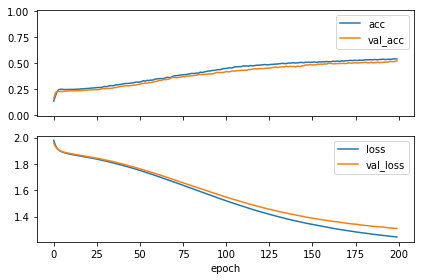

In [66]:
measures = np.unique([k.replace('val_', '') for k in history.history.keys()])
n = len(measures)
x = np.arange(len(history.history[measures[0]]))
fig, axs = plt.subplots(n, 1, squeeze=True, sharex=True, figsize=(6, 2*n), tight_layout=True)
for i, m in enumerate(measures):
    axs[i].plot(x, history.history[m], label=m)
    if f"val_{m}" in history.history.keys():
        axs[i].plot(x, history.history[f"val_{m}"], label=f"val_{m}")
    if m == "acc":
        axs[i].set_ylim((-0.01, 1.01))
    axs[i].legend()
axs[-1].set_xlabel("epoch");

The model picks the correct choice ~50% of the time, which is better than random chance (1/7th, or 14.3% of the time)

Next will be to try convolution: `https://keras.io/api/layers/convolution_layers/convolution2d/`